# Procesamiento de Lenguaje Natural | Análisis de Sentimientos con Twitter (es)

## Importar librerías

In [ ]:
!pip install pyprind

In [ ]:
import os
import sys
import tarfile
import time
import re
import pyprind
import numpy as np
import pandas as pd

In [ ]:
import tweepy as tw

### Habilitar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Obtener permisos de la API de Twetter

In [ ]:
consumer_key = 'u9wwsCjQq7BgY6MVTyMMrWCTD'
consumer_secret = '15fch9r8e8FokSnV5tUbyBkHvl0c3ggfJO1XoR0pMsRrORznyB'
access_token = '1358586629770928139-tKoBpNFnxWxV9ROmji8LJ1npKpHxky'
access_token_secret = 'AERm0fJt2WClhZe4YxIs66I1A3RtDcbw3Ej9cYcWO85bq'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth, wait_on_rate_limit=True)

## Obtener tweets

### El Conjuro 

In [ ]:
search_words = '#ElConjuro' + '-filter:retweets'
date_since = '2020-01-01'

tweets = tw.Cursor(api.search, search_words, 'es', date_since).items(10000)

In [ ]:
data = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tw_df = pd.DataFrame(data=data, columns=['User', 'Location', 'Text'])
tw_df

,User,Location,Text
0,clradiocom,Chile,"#CineyTV Tráiler de ""Expediente Warren: Obliga..."
1,yo_kevinazo,,No sé si aquí me van a vacunar o a exorcizarme...
2,CinafilmEspanol,"Birmingham, England","El conjuro (2013) - Leer 1,149 Críticas de Pel..."
3,RED92cadadiamas,La Plata - Buenos Aires - ARG,😰📽🎞 | #Warren | #ElConjuro | #TheConjuring | #...
4,Moni_Buenfil,"Irapuato, Guanajuato",Participa en el sorteo #ElConjuro @acme_vlogs ...
5,RevistaRayas,"Puebla, México",😱🤩 ¡Morimos de miedo y de ganas de verla! \n\n...
6,PactoCopernico,La Plata,"Ayer, en @PactoCopernico el querido @RodrigoGF..."
7,Hernan_moyano,La Plata,"Ayer, en @PactoCopernico el querido @RodrigoGF..."
8,clradiocom,Chile,"#CineyTV Tráiler de ""Expediente Warren: Obliga..."
9,DoppelgangerEl,,En minutos les cuento mis apreciaciones sobre ...


In [ ]:
tw_df.to_csv('/content/drive/MyDrive/Colab Notebooks/El_Conjuro.csv', index=False, encoding='utf-8')

### Nos Estan Matando

In [ ]:
search_words = '#NosEstanMatando' + '-filter:retweets'
date_since = '2021-01-01'

tweets = tw.Cursor(api.search, search_words, 'es', date_since).items(5000)

In [ ]:
data = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tw_df = pd.DataFrame(data=data, columns=['User', 'Location', 'Text'])
tw_df

,User,Location,Text
0,BrinaWaldo,"Tadó, Colombia",@0vejer0 Quisiera estar en ese mundo y no en e...
1,AlessaGomor,Colombia,#Justicia para todos los masacrados en #Colomb...
2,Santiag65436789,,"@HRI_ONG Hagan algo, necesitamos una intervenc..."
3,cusithemaravish,,@PoliciaColombia #SosPopayan #Popayan #Popayan...
4,JhonJfcardona,#Narnia #DeLaTierraDelCafé,@MariaAntonia_L @JAIMEELROJO Con el regreso d ...
...,...,...,...
604,Aldeana67944701,,#NosEstanMatando Tranquila Inés María Zabarain...
605,ChebyEspejo,Colombia,@ESPNColombia la vida no puede estar por enci...
606,ParisFranccia,Polombia,Esto es de lo peor que ha pasado durante estos...
607,IbeliciP,,"«Cuando la tiranía es ley, la revolución es or..."


In [ ]:
tw_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Paro_Nacional.csv', index=False, encoding='utf-8')

## Obtener Corpus: Corvertir XML a CSV

In [ ]:
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

### Función para listar archivos de un directorio

In [ ]:
def files_of_path(path):
    return [obj.name for obj in os.scandir(path) if obj.is_file()]

files = files_of_path('/content/drive/MyDrive/Colab Notebooks/')

for file in files:
    print(file)

Copia de tutorial1.ipynb
PIT1_TALLER_DEMO.ipynb
PIT4_sklearn_regresion_lineal(load_boston).ipynb
casa_de_papel_twitter_es.csv
casa_de_papel_twitter_es.gsheet
El_Conjuro.csv
Paro_Nacional.csv


### Función para convertir listas a archivos CSV

In [ ]:
def list_to_csv(data, filename):
    with open(filename, 'w', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows(data)

### Función para cargar de un CSV a una Lista (messages | labels)

In [ ]:
def csv_to_lists(filename):
    messages = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            messages.append(row[1])
            labels.append(row[2])
    return messages, labels

### Función para parsear xml en un dataframe

#### corpus de general tweetid | content | sentiments/polarity/value

In [ ]:
def general_tass_2017_to_list(filename, qrel=None):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        polarityValue = qrel[tweetId]
        data.append([tweetId, content.replace('\n', ' '), polarityValue])
    
    return data

#### corpus politics tweetid | content | sentiments/polarity

In [ ]:
def politics_tass_to_list(filename):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
        if aux != None:
            polarityValue = aux.find('value').text
            data.append([tweetId, content.replace('\n', ' '), polarityValue])
    return data

#### corpus de internacional tweetid | content | sentiments/polarity/value

In [ ]:
def intertass_tass_to_list(filename, qrel=None):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        polarityValue = tweet.find('sentiment/polarity/value').text
        if polarityValue == None:
            polarityValue = qrel[tweetId]
            data.append([tweetId, content.replace('\n', ' '), polarityValue])
    return data

#### Funcion para unir los tweets corpus general test con sus sentiments

In [ ]:
def gold_standard_to_dict(filename):
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        data = {rows[0]: rows[1] for rows in reader}
    return data

### Función para separar el 100% del corpus entre Train(70%) y Test(30%)

In [ ]:
 def generate_train_test_subsets(data, size):
     codes = [d[0] for d in data]
     labels = [d[2] for d in data]
     codes_train, codes_test, labels_train, label_test = train_test_split(codes, labels, train_size=size)
     train_data = [d for d in data if d[0] in codes_train]
     test_data = [d for d in data if d[0] in codes_test]
     return train_data, test_data

## Ejecutar cada función de parsear los copus y guardarlo en un CSV(full, train, test)

In [ ]:
data = []

### Parceamos el internacional TASS

Tomamos el corpus internacional (test) y generamos una lista de ID del tweet y el sentimiento para agregarlo a la data

In [ ]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test_res.qrel')

Como el test del corpus internacional esta sin los sentimientos, es necesario agregarlos

In [ ]:
data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test.xml', 
    qrel
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_development.xml'
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Training.xml'   
))

### Parceamos el general TASS

In [ ]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/General Corpus of TASS/general-sentiment-3l.qrel')

In [ ]:
data.extend(general_tass_2017_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/General Corpus of TASS/general-tweets-test.xml',
    qrel
))

### Parceamos el STOMPOL (política) TASS_2014 

In [ ]:
data.extend(politics_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2014/politics-test-tagged.xml'
))

### Separamos la data en Train y Test

In [ ]:
train, test = (generate_train_test_subsets(data, size=0.3))

In [ ]:
list_to_csv(data, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full.csv')
list_to_csv(train, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_train.csv')
list_to_csv(test, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_test.csv')

## Preprocesamiento del corpus

### Cargar librerías necesarias

In [ ]:
import re
from nltk import TweetTokenizer
from nltk.stem import SnowballStemmer

|Librería|Función|
|--------|-------|
|re|Operaciones regulares para la búsqueda y manipulación de cadenas|
|TweetTokenizer|Librería para tokenizar|
|SnowballStemmer|Algoritmo para clasificación de palabras|

Varaibles para mejorar la escritura (opcional)

In [ ]:
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

Definir que el algortimo de clasificación use el idimoa español

In [ ]:
_stemmer = SnowballStemmer('spanish')

Definir una variable para la funcipon de tokenizar (opcional)

In [ ]:
_tokenizer = TweetTokenizer().tokenize

Variable para definir si quiero normalizar o eliminar: remove los hashtag, menciones y urls en los tweets

In [ ]:
_twitter_features = 'normalize'

Variable para definir si se desea convertir o no a la raiz de la palabra

In [ ]:
_stemming = False

### Funciones / métodos de preprocesamiento

#### Listas de Conversión (Quitar tildes y palabras coloquiales)

Lista de conversión para quitar las tildes a las vocales

In [ ]:
DIACRITICAL_VOWELS = [('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')]

Lista para corregir algunas palabras coloquiales / jerga en español (palabras básicas)

In [ ]:
SLANG = [('d', 'de'), ('(q|k)', 'que'), ('[qk]', 'que'), ('xo', 'pero'), ('xa', 'para'), 
         ('[xq]', 'porque'), ('fvr', 'favor'), ('(xfa|xf|pf|plis|pls|porfa)', 'por favor'),
         ('dnd', 'donde'), ('tb', 'tambien'), ('(tq|tk)', 'te quiero'), ('tqm', 'te quiero mucho'),
         ('x', 'por'), ('\+', 'mas'), ('maso', 'mas o menos'), ('(holi|hl)', 'hola'), 
         ('wnas', 'buenas'), ('nd', 'nada'), ('msj', 'mensaje'), ('es3', 'estre'), ('tp', 'tampoco'), 
         ('(wno|weno|bn)', 'bueno'), ('DM', 'mensaje directo'), ('BFF', 'mejores amigos para siempre'),
         ('OMG', 'Oh Dios mio'), ('TBT', 'jueves de vuelta al pasado')]

#### Función / método de normalización de risas

In [ ]:
def normalize_laughs(message):
    message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[h])[aeiouh]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
    return message

In [ ]:
print(normalize_laughs('jajaja, jejeje, Lol, hohoho, kokoko'))

twlaugh, twlaugh, twlaugh, twlaugh, twlaugh


#### Función / método para eliminar o normalizar menciones, hashtags y URL de un mensaje (tweet)

In [ ]:
def process_twiter_features(message, twitter_features):
    message = re.sub(r'[\.\,]http', '. http', message, flags=re.IGNORECASE)
    message = re.sub(r'[\.\,]#', '. #', message)
    message = re.sub(r'[\.\,]@', '. @', message)
    if twitter_features == REMOVE:
        # Eliminar menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
        message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
    elif twitter_features == NORMALIZE:
        # Cuando sea necesario se normalizaran las menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
        message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
        message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)
    return message

In [ ]:
print(process_twiter_features('@MarvelStudios, #MarvelStudios, https://marvelstudios.com', 'normalize'))

twmention twhashtag twurl


#### Función / método general para el preprocesamiento

In [ ]:
def preprocess(message):
    message = message.lower()

    # Eliminar números, retorno de línea y los retweet(antiguos estilos de twitter)
    message = re.sub(r'(\d+|\n|\brt\b)', '', message)

    # Eliminar vocales con signos diacríticos (posibles ambigüedades)
    for s,t in DIACRITICAL_VOWELS:
        message = re.sub(r'{0}'.format(s), t, message)

    # Eliminar caracteres repetidos
    message = re.sub(r'(.)\1{2,}', r'\1\1', message)
    
    # Normalizar las risas
    message = normalize_laughs(message)

    # Traducir la jerga y terminos coloquiales sobre todo en el español
    for s,t in SLANG:
        message = re.sub(r'\b{0}\b'.format(s), t, message)
    
    # Normalizar - eliminar hashtags, menciones y URL
    message = process_twiter_features(message, _twitter_features)

    # Convertir las palabras a su raiz (Bonito, Bonita --> bonit)
    if _stemming: 
        message = ' '.join(_stemer.stem(w) for w in _tokenizer(message))

    return message

In [ ]:
print(preprocess("jajaja, @MarvelStudios, #MarvelStudios, https://www.marvel.com/movies"))

twlaugh, twmention twhashtag twurl


### Descargar las librerías NLTK

Descargamos la librería de stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Cargamos el CSV del corpus

### Aplicamos preprocesamiento al CSV y creamos un nuevo CSV limplio

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full.csv',
    encoding='utf-8')

Asignamos nombres a las columnas del csv para facilitar la búsqueda de información

In [ ]:
df.columns = ['tweetid', 'tweet', 'sentiment']

Aplicamos el preprocesamiento a los tweets con steaming = False

In [ ]:
df['tweet'] = df['tweet'].apply(preprocess)

Eliminamos la columna tweetid que no nos sirve para entrenar y si genera más uso de memoria

In [ ]:
df = df.drop(columns='tweetid')

Es mejor trabajar con valores enteros que con letras, por lo tanto reemplazaremos los sentimientos que estan como:

|Valor Actual|Nuevo Valor|
|------------|-----------|
|NONE|-1|
|NEU|0|
|P|1|
|N|2|

In [ ]:
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df['sentiment'].unique()

array(['1', '2', '-1', '0'], dtype=object)

Guardamos el dataset en un nuevo CSV para facilitar su posterior uso

In [ ]:
df.to_csv(
    '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv', 
    index=False, 
    encoding='utf-8')

## Entrenar el modelo de aprendizaje

### Funciones para tokenizar y extraer tweets

#### Función para tokenizar y limpiar

In [ ]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

#### Función para extraer un documento del dataset

In [ ]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)       # Skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

#### Función que tomara una secuencia de documentos y devolvera un número particular de documentos

In [ ]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [ ]:
next(stream_docs(path='/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv'))

('twmention ya era hora de volver al csgo y dejares el padel bienvenida ', 1)

## Entrenamos el modelo con regresión logística

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv'

Definimos una versión liviana de CountVectorizer + TfidfVectorizer llamada HashingVectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [ ]:
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Definimos como algoritmo la regresión logística en el descenso gradiente

In [ ]:
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)

Entrenamiento

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('spanish')

Definimos las clases con las cuales vamos a entrenar

In [ ]:
classes = np.array([-1, 0, 1, 2])

In [ ]:
pbar = pyprind.ProgBar(50)

for _ in range(50):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Probamos la eficiencia del modelo con 5000 tweets

In [ ]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)

In [ ]:
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.805


Recalibramos el modelo

In [ ]:
clf = clf.partial_fit(X_test, y_test)

## Serializamos / Congelamos el modelo para usarlo fuera de Google Colaboratory

In [ ]:
import pickle

Creamos una carpeta en el drive para guardar los archivos serializados

In [ ]:
dest = os.path.join('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

Convertimos el clasificador y el stopword en archivo/objetos pkl. Es importante verificar que si se encuentran en dicho directorio

In [ ]:
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Para probar si funciona, cambiamos la basepath (directorio por defecto) de Python a la carpeta de TwitterClassifier

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier')

Deserializamos los estimadores

In [ ]:
clf = pickle.load(
    open(
        os.path.join('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier/pkl_objects', 
                     'classifier.pkl'), 
         'rb'))

Clasifiquemos un texto de ejemplo

In [ ]:
label = {-1:'Sin sentimientos', 0:'Neutro', 1:'Positivo', 2:'Negativo'}

In [ ]:
frase = 'Estoy alegre por la nueva pelicula del conjuro'
example = [frase]

Convertimos el texto en un vecot de palabras y extraemos sus caracteristicas https://scikit-learn.org/stable/modules/feature_extraction.html

In [ ]:
textConvert = vect.transform(example)

print('Predicción: %s \nProbabilidad: %.2f%%' % (label[clf.predict(textConvert)[0]], np.max(clf.predict_proba(textConvert))*100))
print('Predicción: %s' % label[clf.predict(textConvert)[0]])
print(np.max(clf.predict_proba(textConvert))*100)

Predicción: Positivo 
Probabilidad: 81.84%
Predicción: Positivo
81.84307594442375


## Recorremos los tweets descargados y los clasificamos

In [ ]:
pbar = pyprind.ProgBar(50000)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/El_Conjuro.csv', encoding='utf-8')

Creamos una columna llamada Sentiment donde guardamos la predicción y otra columna llamada Probability donde almacenaremos la acertabilidad que dio el clasificador

In [ ]:
df['sentiment'] = ''
df['probability'] = 0

Conversion de sentimientos (números a palabras)

In [ ]:
for rowid in range(len(df.index)):
    text = df['Text'][rowid]
    textConvert = vect.transform([text])
    df['sentiment'][rowid] = label[clf.predict(textConvert)[0]]
    df['probability'][rowid] = np.max(clf.predict_proba(textConvert))*100
    pbar.update()
df.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,User,Location,Text,sentiment,probability
0,clradiocom,Chile,"#CineyTV Tráiler de ""Expediente Warren: Obliga...",Positivo,63
1,yo_kevinazo,NaN,No sé si aquí me van a vacunar o a exorcizarme...,Positivo,60
2,CinafilmEspanol,"Birmingham, England","El conjuro (2013) - Leer 1,149 Críticas de Pel...",Positivo,66
3,RED92cadadiamas,La Plata - Buenos Aires - ARG,😰📽🎞 | #Warren | #ElConjuro | #TheConjuring | #...,Positivo,65
4,Moni_Buenfil,"Irapuato, Guanajuato",Participa en el sorteo #ElConjuro @acme_vlogs ...,Positivo,68
5,RevistaRayas,"Puebla, México",😱🤩 ¡Morimos de miedo y de ganas de verla! \n\n...,Positivo,63
6,PactoCopernico,La Plata,"Ayer, en @PactoCopernico el querido @RodrigoGF...",Positivo,64
7,Hernan_moyano,La Plata,"Ayer, en @PactoCopernico el querido @RodrigoGF...",Positivo,64
8,clradiocom,Chile,"#CineyTV Tráiler de ""Expediente Warren: Obliga...",Positivo,63
9,DoppelgangerEl,NaN,En minutos les cuento mis apreciaciones sobre ...,Positivo,71


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/El_Conjuro.csv', index=False, encoding='utf-8')

Segunda forma de ejecutar el análisis (métodos)

In [ ]:
def f_prediction(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

In [ ]:
def f_probability(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

In [ ]:
df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Positivo    14
dtype: int64


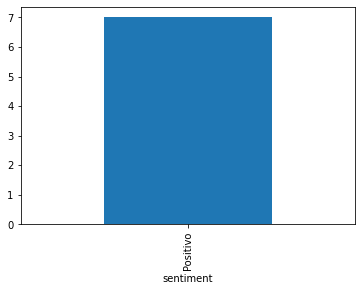

In [ ]:
import matplotlib.pyplot as plt

df.groupby('sentiment')['Location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
plt.show()

## Recorremos los tweets descargados y los clasificamos

In [ ]:
pbar = pyprind.ProgBar(50000)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Colombia/Paro_Nacional.csv', encoding='utf-8')

Creamos una columna llamada Sentiment donde guardamos la predicción y otra columna llamada Probability donde almacenaremos la acertabilidad que dio el clasificador

In [ ]:
df['sentiment'] = ''
df['probability'] = 0

Conversion de sentimientos (números a palabras)

In [ ]:
for rowid in range(len(df.index)):
    text = df['Text'][rowid]
    textConvert = vect.transform([text])
    df['sentiment'][rowid] = label[clf.predict(textConvert)[0]]
    df['probability'][rowid] = np.max(clf.predict_proba(textConvert))*100
    pbar.update()
df.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
0% [###                           ] 100% | ETA: 00:39:41

,User,Location,Text,sentiment,probability
0,johamos06,NaN,Estoy totalmente de acuerdo con el #ParoNacion...,Positivo,54
1,eseljeexx,España,Mrc ya no se trata de si la arepa es de Colomb...,Positivo,72
2,BambamSteven_,Puerto Wilches - Pamplona,"El pueblo no mata al pueblo, es increíble lo q...",Positivo,64
3,Davidhern10,"Barcelona, España","Estado paramilitar, estado Genocida. Me duele ...",Positivo,58
4,edgardoalcendra,Colombia,Se metieron con la generación que todo lo grab...,Positivo,60
5,EstherJinete,Colombia,@HFCardonaG No puedo creer que alguien que sie...,Positivo,67
6,nicolastorrest6,NaN,El día de hoy en Colombia es como jugar monopo...,Positivo,77
7,andreah22735593,Argentina,En Medellín en este momento en el@parque de la...,Positivo,69
8,Alejand72037901,"Bogotá, D.C., Colombia",Me le paro a ese man y le aplaudo. Chico desco...,Negativo,53
9,RugeJaimes,"Bogotá, D.C., Colombia",Voy en bus a soacha y vengo escuchando una con...,Positivo,73


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Colombia/Paro_Nacional_sentiment.csv', index=False, encoding='utf-8')

Segunda forma de ejecutar el análisis (métodos)

In [ ]:
def f_prediction(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

In [ ]:
def f_probability(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

In [ ]:
df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo     891
Positivo    4109
dtype: int64


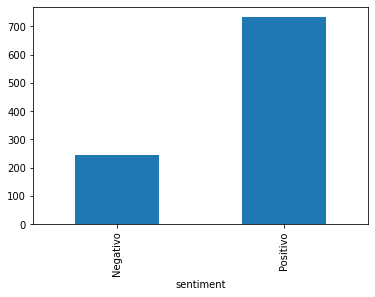

In [ ]:
import matplotlib.pyplot as plt

df.groupby('sentiment')['Location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
plt.show()

## Hacer uso de SQLite

### Generar DB de sqlite

In [ ]:
import sqlite3
import os

if os.path.exists('tweets.sqlite'):
    os.remove('tweets.sqlite')

conn = sqlite3.connect('tweets.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE tweets_db (tweet TEXT, sentiment INTEGER, date TEXT)')

example1 = 'que aburrido es estar en cuarentena…'
c.execute("INSERT INTO tweets_db (tweet, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 2))

example2 = 'Estoy feliz de estar con mi familia'
c.execute("INSERT INTO tweets_db (tweet, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 1))

conn.commit()
conn.close()

### Consultar la DB

In [ ]:
conn = sqlite3.connect('tweets.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM tweets_db WHERE date BETWEEN '2019-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()
conn.close()

print(results)

[('que aburrido es estar en cuarentena…', 2, '2021-05-15 05:01:35'), ('Estoy feliz de estar con mi familia', 1, '2021-05-15 05:01:35')]
